# Chapter 5 - Estimating counts
http://allendowney.github.io/ThinkBayes2/chap05.html#informative-priors

## Reading

In [1]:
# Get utils.py

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ThinkBayes2/raw/master/soln/utils.py')

from utils import set_pyplot_params
set_pyplot_params()

## The train problem

In [2]:
import numpy as np
from empiricaldist import Pmf

hypos = np.arange(1, 1001)
prior = Pmf(1, hypos)

In [3]:
def update_train(pmf, data):
    hypos = pmf.qs
    likelihood = 1 / hypos
    impossible = data > hypos
    likelihood[impossible] = 0
    pmf *= likelihood
    pmf.normalize()

In [4]:
data = 60
posterior = prior.copy()
update_train(posterior, data)

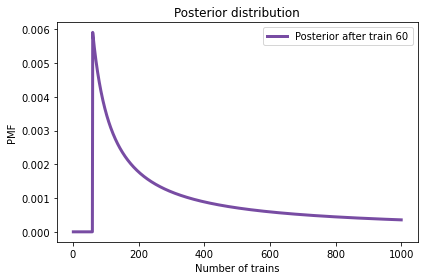

In [5]:
from utils import decorate

posterior.plot(label='Posterior after train 60', color='C4')
decorate(xlabel='Number of trains',
         ylabel='PMF',
         title='Posterior distribution')

In [6]:
posterior.max_prob()

60

In [7]:
np.sum(posterior.ps * posterior.qs)

333.41989326370776

In [8]:
posterior.mean()

333.41989326370776

### Sensitivity to the Prior

In [9]:
import pandas as pd

df = pd.DataFrame(columns=['Posterior mean'])
df.index.name = 'Upper bound'

for high in [500, 1000, 2000]:
    hypos = np.arange(1, high+1)
    pmf = Pmf(1, hypos)
    update_train(pmf, data=60)
    df.loc[high] = pmf.mean()
    
df

,Posterior mean
Upper bound,
500,207.079228
1000,333.419893
2000,552.179017


### Getting more data

In [10]:
df = pd.DataFrame(columns=['Posterior mean'])
df.index.name = 'Upper bound'

dataset = [30, 60, 90]

for high in [500, 1000, 2000]:
    hypos = np.arange(1, high+1)
    pmf = Pmf(1, hypos)
    for data in dataset:
        update_train(pmf, data)
    df.loc[high] = pmf.mean()
    
df

,Posterior mean
Upper bound,
500,151.849588
1000,164.305586
2000,171.338181


### Power law prior

In [11]:
alpha = 1.0
ps = hypos**(-alpha)
power = Pmf(ps, hypos, name='power law')
power.normalize()

8.178368103610282

In [13]:
# Uniform prior for comparison
hypos = np.arange(1, 1001)
uniform = Pmf(1, hypos, name='uniform')
uniform.normalize()

1000

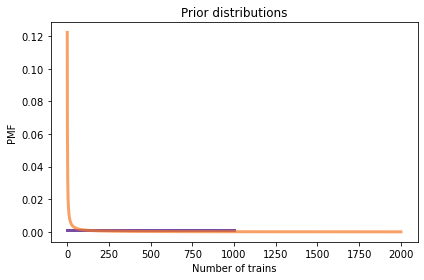

In [14]:
uniform.plot(color='C4')
power.plot(color='C1')

decorate(xlabel='Number of trains',
         ylabel='PMF',
         title='Prior distributions')

In [15]:
dataset = [60]
update_train(uniform, dataset)
update_train(power, dataset)

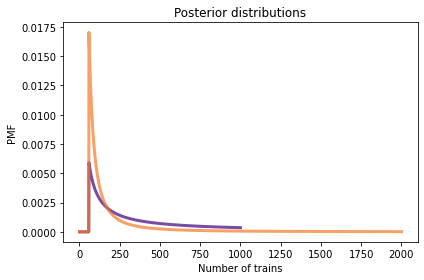

In [16]:
uniform.plot(color='C4')
power.plot(color='C1')

decorate(xlabel='Number of trains',
         ylabel='PMF',
         title='Posterior distributions')

In [17]:
df = pd.DataFrame(columns=['Posterior mean'])
df.index.name = 'Upper bound'

alpha = 1.0
dataset = [30, 60, 90]

for high in [500, 1000, 2000]:
    hypos = np.arange(1, high+1)
    ps = hypos**(-alpha)
    power = Pmf(ps, hypos)
    for data in dataset:
        update_train(power, data)
    df.loc[high] = power.mean()
    
df

,Posterior mean
Upper bound,
500,130.708470
1000,133.275231
2000,133.997463


### Credible intervals

In [18]:
def quantile(pmf, prob):
    """Compute a quantile with the given probability."""
    total = 0
    for q, p in pmf.items():
        total += p
        if total >= prob:
            return q
    return np.nan

In [19]:
quantile(power, 0.5)

113

In [20]:
power.quantile([0.05, 0.95])

array([ 91., 243.])

In [21]:
power.credible_interval(0.9)

array([ 91., 243.])

## Exercises

**Exercise:** Suppose you are giving a talk in a large lecture hall and the fire marshal interrupts because they think the audience exceeds 1200 people, which is the safe capacity of the room. 

You think there are fewer then 1200 people, and you offer to prove it.
It would take too long to count, so you try an experiment:

* You ask how many people were born on May 11 and two people raise their hands.  

* You ask how many were born on May 23 and 1 person raises their hand.  
* Finally, you ask how many were born on August 1, and no one raises their hand.

How many people are in the audience?  What is the probability that there are more than 1200 people.
Hint: Remember the binomial distribution.

In [22]:
from scipy.stats import binom

In [41]:
hypos = np.arange(100, 2000)
prior = Pmf(1, hypos)
prior.normalize()

1900

Probability of $k$ people having a specific day as birthday:
- ${n \choose k} (\frac{1}{365})^k (1 - \frac{1}{365})^{n - k}$

In [43]:
N = hypos
likelihood = binom.pmf(2, N, 1/365) * binom.pmf(1, N, 1/365) * binom.pmf(0, N, 1/365)

In [44]:
posterior = prior * likelihood
posterior.normalize()

0.007045425901588252

In [45]:
posterior.max_prob()

365

In [47]:
posterior.mean()

490.2386480298125

In [46]:
posterior.prob_gt(1200)

0.01134731317520143

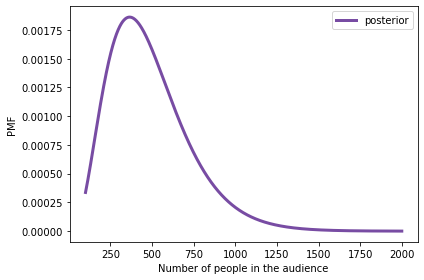

In [48]:
posterior.plot(color='C4', label='posterior')
decorate(xlabel='Number of people in the audience',
         ylabel='PMF')

**Exercise:** I often see [rabbits](https://en.wikipedia.org/wiki/Eastern_cottontail) in the garden behind my house, but it's not easy to tell them apart, so I don't really know how many there are.

Suppose I deploy a motion-sensing [camera trap](https://en.wikipedia.org/wiki/Camera_trap) that takes a picture of the first rabbit it sees each day.  After three days, I compare the pictures and conclude that two of them are the same rabbit and the other is different.

How many rabbits visit my garden?

To answer this question, we have to think about the prior distribution and the likelihood of the data:

* I have sometimes seen four rabbits at the same time, so I know there are at least that many.  I would be surprised if there were more than 10.  So, at least as a starting place, I think a uniform prior from 4 to 10 is reasonable.

* To keep things simple, let's assume that all rabbits who visit my garden are equally likely to be caught by the camera trap in a given day.  Let's also assume it is guaranteed that the camera trap gets a picture every day.

In [25]:
# Uniform prior from 4 to 10
hypos = np.arange(4, 11)
prior = Pmf(1, hypos)
prior.normalize()

7

In [32]:
# Probability second rabbit same as first is 1 / N
# Probability third rabbit is different is (N - 1) / N

N = hypos

likelihood = 1 / N * (N - 1) / N

posterior = prior * likelihood
posterior.normalize()

0.129568328654213

In [33]:
posterior.max_prob()

4

In [34]:
posterior.mean()

6.509929813748172

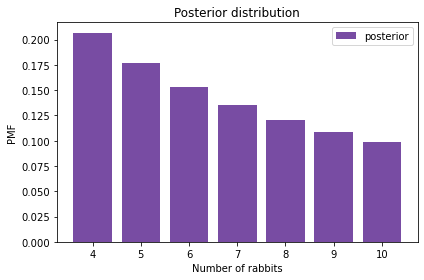

In [40]:
posterior.bar(label='posterior', color='C4')
decorate(xlabel='Number of rabbits',
         ylabel='PMF',
         title='Posterior distribution')


**Exercise:** Suppose that in the criminal justice system, all prison sentences are either 1, 2, or 3 years, with an equal number of each.  One day, you visit a prison and choose a prisoner at random.  What is the probability that they are serving a 3-year sentence?  What is the average remaining sentence of the prisoners you observe?

In [51]:
# Uniform distribution of 1, 2, and 3 years
hypos = np.arange(1, 4)
prior = Pmf(1, hypos)
prior.normalize()

3

In [52]:
prior

,probs
1,0.333333
2,0.333333
3,0.333333


The chance you are encountering a prisoner is proportional to how long they are serving.

In [53]:
likelihood = hypos
posterior = prior * likelihood
posterior.normalize()
posterior

,probs
1,0.166667
2,0.333333
3,0.500000


So there is a 50% chance that a prisoner you encounter is serving a 3 year sentence.

You could be encountering prisoners on any day of their sentence uniformly, so the mean time left for each sentence is 50% of the length of the sentence.

So the mean time left overall is the mean length of the sentence.

In [59]:
posterior.mean() / 2

1.1666666666666665

**Exercise:** If I chose a random adult in the U.S., what is the probability that they have a sibling?  To be precise, what is the probability that their mother has had at least one other child.

[This article from the Pew Research Center](https://www.pewsocialtrends.org/2015/05/07/family-size-among-mothers/) provides some relevant data.  

From it, I extracted the following distribution of family size for mothers in the U.S. who were 40-44 years old in 2014:

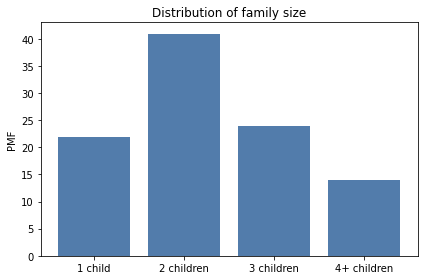

In [60]:
import matplotlib.pyplot as plt

qs = [1, 2, 3, 4]
ps = [22, 41, 24, 14]
prior = Pmf(ps, qs)
prior.bar(alpha=0.7)

plt.xticks(qs, ['1 child', '2 children', '3 children', '4+ children'])
decorate(ylabel='PMF',
         title='Distribution of family size')

For simplicity, let's assume that all families in the 4+ category have exactly 4 children.

---
I think we want the probability of 2 or more children in the family. The number of siblings of a person we encounter is proportional to the size of their family.

In [61]:
likelihood = qs

posterior = prior * likelihood
posterior.normalize()

232

In [62]:
posterior

,probs
1,0.094828
2,0.353448
3,0.310345
4,0.241379


In [63]:
# Chance of 2 or more children
1 - posterior[1]

0.9051724137931034

**Exercise:** The [Doomsday argument](https://en.wikipedia.org/wiki/Doomsday_argument) is "a probabilistic argument that claims to predict the number of future members of the human species given an estimate of the total number of humans born so far."

Suppose there are only two kinds of intelligent civilizations that can happen in the universe.  The "short-lived" kind go extinct after only 200 billion individuals are born.  The "long-lived" kind survive until 2,000 billion individuals are born.
And suppose that the two kinds of civilization are equally likely.
Which kind of civilization do you think we live in?  

The Doomsday argument says we can use the total number of humans born so far as data.
According to the [Population Reference Bureau](https://www.prb.org/howmanypeoplehaveeverlivedonearth/), the total number of people who have ever lived is about 108 billion.

Since you were born quite recently, let's assume that you are, in fact, human being number 108 billion.
If $N$ is the total number who will ever live and we consider you to be a randomly-chosen person, it is equally likely that you could have been person 1, or $N$, or any number in between.
So what is the probability that you would be number 108 billion?

Given this data and dubious prior, what is the probability that our civilization will be short-lived?

In [64]:
hypos = np.array([200, 2000])
prior = Pmf(1, hypos)
prior.normalize()

likelihood = 1 / hypos

pmf = prior * likelihood

pmf.normalize()

pmf

,probs
200,0.909091
2000,0.090909
